# How to Reduce Churn at Telco

by Kaniela Denis, 29 November 2011

## Project Goal

The goal of this project is to identify attributes of customers that churn and based on those attributes  provide a recommendation that will increase customer retention.

## Project Description

Anaylize customers that churn, identify significant attributes, then based on those attributes, build a machine learning model that will predict the probablity of a customer churning, provide a recommendation to reduce churn for a subgroup, and deliver a list of customers that are predicted to churn (delivered via csv).

## Initial Questions

1. How many customers are churning and not churning?

2. What is the timeline of churn?

3. At what month of tenure are they churning?

4. What non-monetary attributes are associated with churned customers?

5. What monetary attributes are associated with churned customers?

6. Do monetary attributes outweigh non-monetary drivers?

7. What drivers are easiest to change with least amount of impact to the customer?

## Data Dictionary

| Variable              | Meaning                                                                           |
|:----------------------|:----------------------------------------------------------------------------------|
| customer_id           | alphas numeric identifer for each customer                                        |
| gender                | if customer is male or female                                                     |
| senior_citizen        | if customer is a senior citizen or not                                            |
| partner               | if customer has a partner or not                                                  |
| dependents            | if customer has dependents or not                                                 |
| tenure                | number of months the customer has been with telco                                 |
| phone_service         | if customer has phone service or not                                              |
| multiple_lines        | if customer has phone multiple phone lines or not, or no phone service            |
| online_security       | if customer has online security or not, or no internet service                    |
| online_backup         | if customer has online backup or not, or no internet service                      |
| device_protection     | if customer has device protection or not, or no internet service                  |
| tech_support          | if customer has tech support or not, or no internet service                       |
| streaming_tv          | if customer has streaming tv or not, or no internet service                       |
| streaming_movies      | if customer has streaming movies or not, or no internet service                   |
| paperless_billing     | if custome has paperless billing or not                                           |
| monthly_charges       | amount paid by custome per month                                                  |
| total_charges         | total amount paid by customer over tenure                                         |
| churn                 | if customer has left telco or not                                                 |
| contract_type         | if customer has a month-to-month, 1 year, or 2 year contract                      |
| internet_service_type | if customer's internet service is fiber optic, DSL, or no internet service        |
| payment_type          | payment is mailed check, electronic check, auto credit card, or auto bank account |

## Wrangle Telco Data
### Acquire Data

To acquire the telco data, I used the **telco_db** from our MySQL server and select all columns from all tables (customers, contact_types, internet_service_types, and payment_types) in the database. 

`SELECT * FROM customers c
JOIN contract_types ct ON ct.contract_type_id=c.contract_type_id
JOIN internet_service_types ist ON ist.internet_service_type_id=c.internet_service_type_id
JOIN payment_types pt ON pt.payment_type_id=c.payment_type_id`

In [1]:
# import common libraries for data manipulations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# import ignore warnings
import warnings
warnings.filterwarnings("ignore")

#import classification algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

#import model reporting
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# import custom functions
import acquire_telco
import prep_telco

# connect to our MySQL server and run the query to return a datafram of all tables in telco_db
df = acquire_telco.get_telco()

## Clean Data

To clean the data, I did the following: 
1. Removed duplicate columns
2. Filled in blank values in column 'total_charges' with zero.
3. Converted data type of 'total_charges' to float.
4. Created payment column that combined auto and manual payment types.

In [2]:
# run clean_telco on telco data
df = prep_telco.clean_telco(df)

## Data Context

- Data is from 7,043 customers of which 1,869 have churned, a 27% churn rate

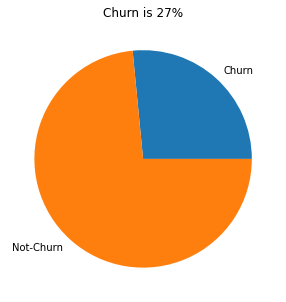

In [3]:
# Visual of Churned Customers to Total Customers
labels=['Churn','Not-Churn']
plt.figure(figsize=(15,5))
plt.pie([df.churn_yes.sum(),df.churn_no.sum()], labels=labels)
plt.title('Churn is 27%')
plt.show()

### Significant Subgroups:
1. Not senior citizen: 5,901
2. No dependents: 4,933
3. Phone service: 6,631
4. No Online Security: 2,019 
5. No Tech Support: 3,473
6. Paperless billing: 4,171
7. Month-to-month contract: 3,875
8. Manual payment: 3,977

## Split the Data

In [4]:
# Run split_telco function from the imported prep_telco file
train, validate, test = prep_telco.split_telco(df)

- Data is now split into 3 samples of train, validate, and test.
- Split is 56% for train, 24% for validate, and 20% for test
- Train sample is used to explore and fit the data to models. 
- Validate sample is used to confirm the models are not overfit to the train data. 
- Test sample is used to provide a final confirmation that the best model is not overfit to the train data. 

## Exploratory Analysis: Which Customers are Most Likely to Churn? 

I have answered the following questions:

1. What is the timeline of churn?

2. What are significant people attributes associated with significant churn?

3. What are significant service attributes associated with significant churn?

4. Do people attributes outweigh service attributes?

5. Is the average churn from customers using **manual payment** greater than the average churn of all customers?

6. For customers on month-to-month contract and using manual payment, is churn greater for those using **paperless billing** than those having **no dependents**?

### Question 1

What is the timeline of churn?

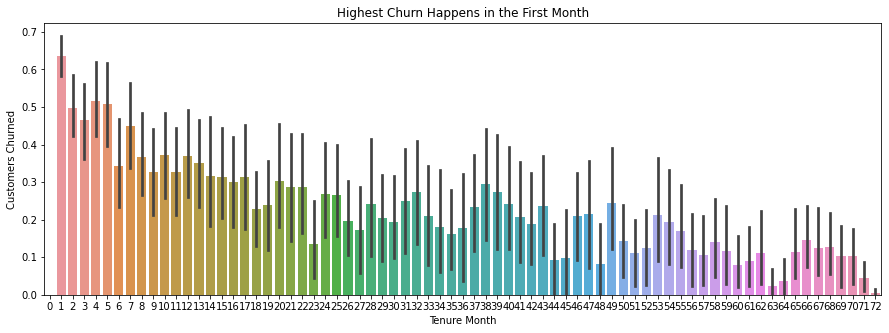

In [5]:
# Show Timeline for Churn
plt.figure(figsize=(15,5))
sns.barplot(data=train, x='tenure', y='churn_yes')
plt.title('Highest Churn Happens in the First Month')
plt.xlabel('Tenure Month')
plt.ylabel('Customers Churned')
plt.show()

### Answer 1

Highest Churn happens in month 1 of tenure. 

### Question 2

What are significant people attributes associated with significant churn?

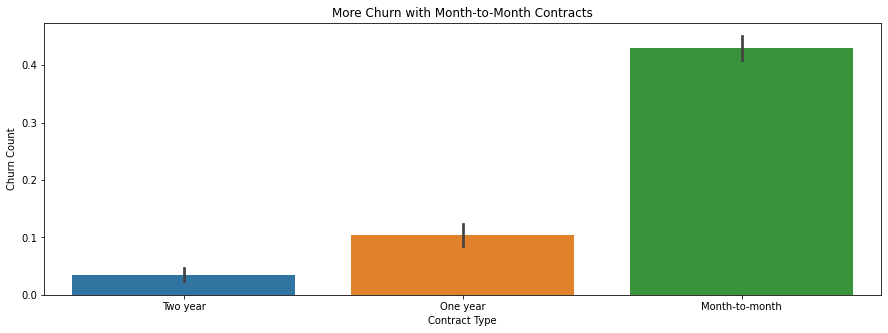

In [6]:
# Graph: Churn for Customers with Month-to-Month Contracts
plt.figure(figsize=(15,5))
sns.barplot(data=train, x=train.contract_type, y=train.churn_yes)
plt.title('More Churn with Month-to-Month Contracts')
plt.xlabel('Contract Type')
plt.ylabel('Churn Count')
plt.show()

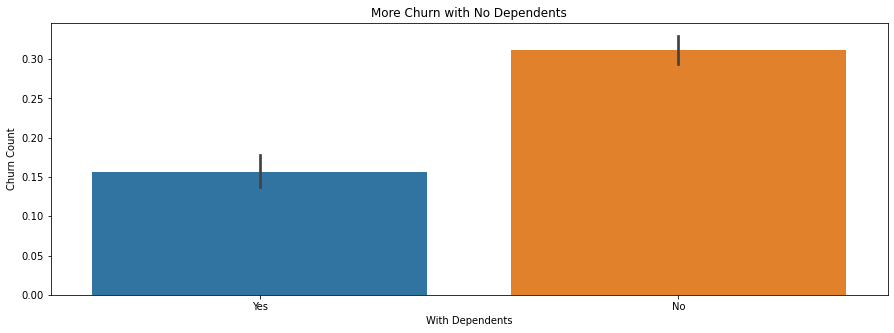

In [7]:
# Graph: Churn for customers with No Dependents
plt.figure(figsize=(15,5))
sns.barplot(data=train, x=train.dependents, y=train.churn_yes)
plt.title('More Churn with No Dependents')
plt.xlabel('With Dependents')
plt.ylabel('Churn Count')
plt.show()

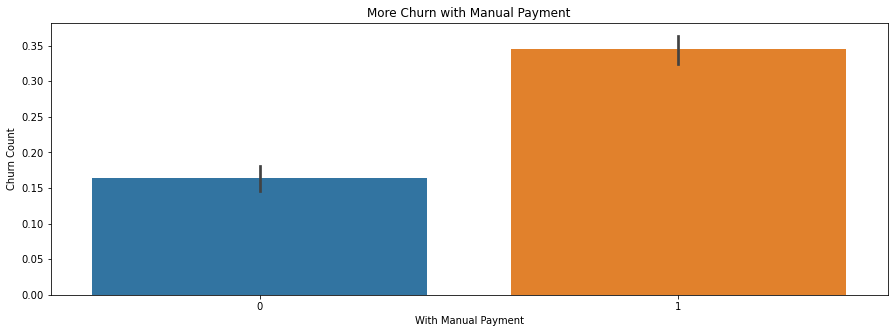

In [8]:
# Graph: Churn for Customer with Manual Payment Type
plt.figure(figsize=(15,5))
sns.barplot(data=train, x=train.payment_manual, y=train.churn_yes)
plt.title('More Churn with Manual Payment')
plt.xlabel('With Manual Payment')
plt.ylabel('Churn Count')
plt.show()

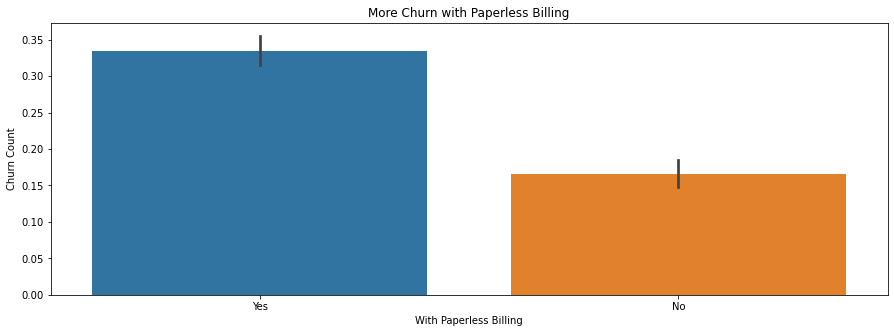

In [9]:
# Graph: Churn for Customers with paperless billing
plt.figure(figsize=(15,5))
sns.barplot(data=train, x=train.paperless_billing, y=train.churn_yes)
plt.title('More Churn with Paperless Billing')
plt.xlabel('With Paperless Billing')
plt.ylabel('Churn Count')
plt.show()

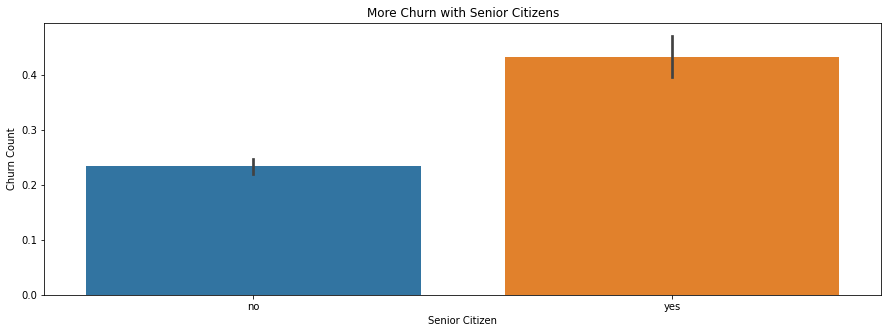

In [10]:
# Graph: Churn for Customers that are Not Senior Citizens
plt.figure(figsize=(15,5))
sns.barplot(data=train, x=train.senior_citizen, y=train.churn_yes)
plt.title('More Churn with Senior Citizens')
plt.xlabel('Senior Citizen')
plt.ylabel('Churn Count')
plt.show()

### Answer 2

Based on significant subgroups, customers with month-to-month contract, with no dependents, with manual payements, or with paperless billing, have significant churn.  

### Question 3

What are significant service attributes associated with significant churn?

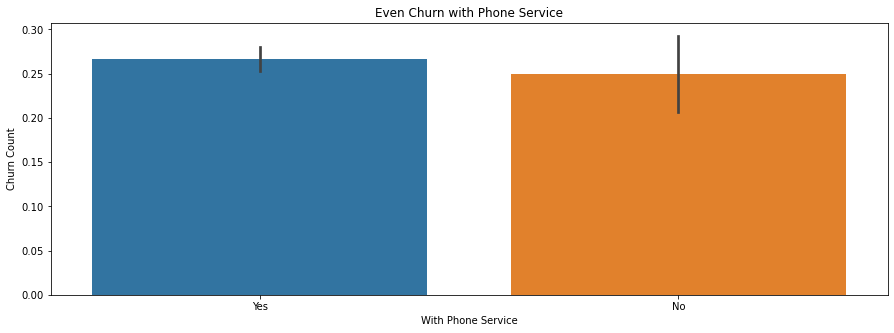

In [11]:
# Graph: Churn for customers with phone service
plt.figure(figsize=(15,5))
sns.barplot(data=train, x=train.phone_service, y=train.churn_yes)
plt.title('Even Churn with Phone Service')
plt.xlabel('With Phone Service')
plt.ylabel('Churn Count')
plt.show()

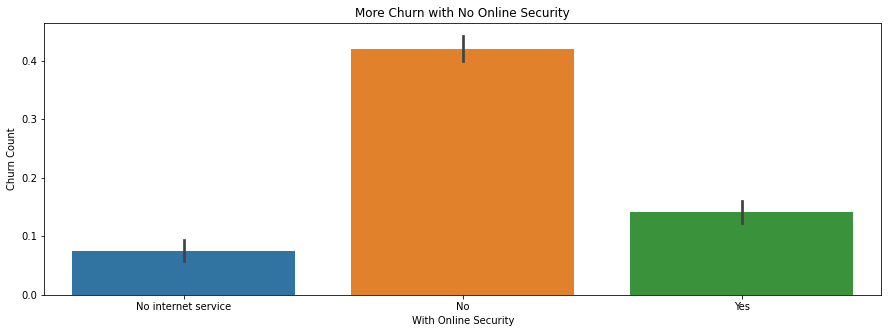

In [12]:
# Graph: Churn for customers with no online security
plt.figure(figsize=(15,5))
sns.barplot(data=train, x=train.online_security, y=train.churn_yes)
plt.title('More Churn with No Online Security')
plt.xlabel('With Online Security')
plt.ylabel('Churn Count')
plt.show()

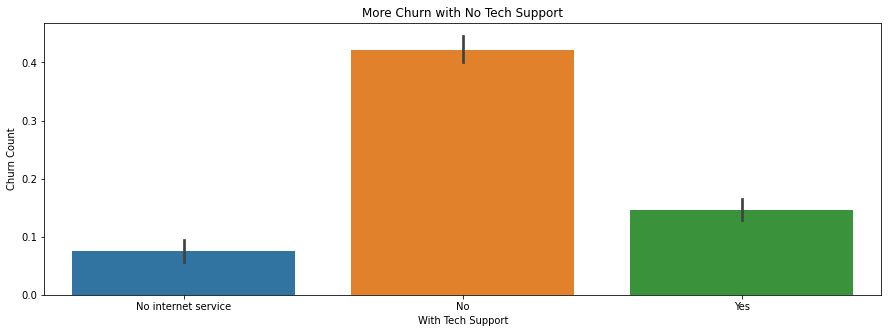

In [13]:
# Graph: Churn for customers with no tech support
plt.figure(figsize=(15,5))
sns.barplot(data=train, x=train.tech_support, y=train.churn_yes)
plt.title('More Churn with No Tech Support')
plt.xlabel('With Tech Support')
plt.ylabel('Churn Count')
plt.show()

### Answer 3

Based on significant subgroups, customers with no online security or no tech support have significant churn.  

### Question 4

Do people attributes outweigh service attributes?

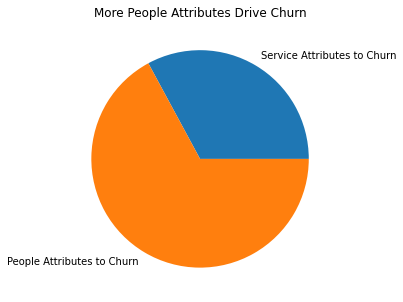

In [14]:
# Churn Count for people attributes vs service attributes
service_count = train[train.online_security_no==1].churn_yes.sum() + train[train.tech_support_no==1].churn_yes.sum()
people_count = train[train.contract_type_month_to_month==1].churn_yes.sum() + train[train.payment_manual==1].churn_yes.sum() + train[train.dependents_no==1].churn_yes.sum() + train[train.paperless_billing_yes==1].churn_yes.sum()

# Visual of Customer using Auto vs Manual Payment Method
plt.figure(figsize=(15,5))
labels = ['Service Attributes to Churn', 'People Attributes to Churn']
plt.pie([service_count, people_count], labels=labels)
plt.title('More People Attributes Drive Churn')
plt.show()

### Answer 4

There are more people related attributes and they also associate to a higher number of churned customers

### Question 5

Is the average churn for customers using manual payments greater than the average churn of all customers?

In [15]:
# Using Single Sample T-Test to see if average manual payment churn is greater than average overall churn
avg_overall_churn = train.churn_yes.mean()
manual_pay_churn = train[train.payment_manual==1].churn_yes
alpha = .05

t, p = stats.ttest_1samp(manual_pay_churn, avg_overall_churn)
print(f'T value is: {t}')
print(f'P value is: {p/2}')
print(f'Alpha is {alpha}')

T value is: 7.837313833751733
P value is: 3.546611271217773e-15
Alpha is 0.05


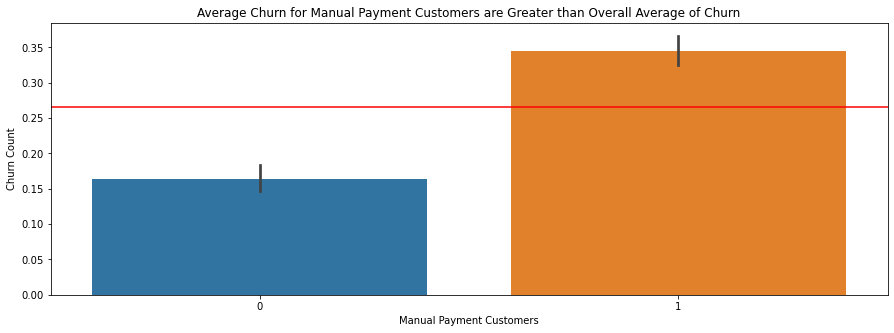

In [16]:
# Visual of Average Churn of Manual Payment vs Average Overall Churn
plt.figure(figsize=(15,5))
sns.barplot(data=train, x=train.payment_manual, y=train.churn_yes)
plt.title('Average Churn for Manual Payment Customers are Greater than Overall Average of Churn')
plt.xlabel('Manual Payment Customers')
plt.ylabel('Churn Count')
plt.axhline(y=avg_overall_churn, color='red')
plt.show()

### Answer 5 
- The visual shows that the average churn of customer using manual payments is higher than the averge of all customer churn.
- The T-Test has a probability lower than alpha indicating agreement with the visual

### Question 6

For customers on month-to-month contract and using manual payment, is churn greater when using paperless billing than when having no dependents? 

In [17]:
# Create data frame of customers on month-to-month contracts using manual payments
df_mpay = train[(train.payment_manual == 1) & (train.contract_type_month_to_month == 1)]

# compare customers without dependents against customers with paperless billing
mp_nd = df_mpay[df_mpay.dependents_no == 1].churn_yes
mp_pb = df_mpay[df_mpay.paperless_billing_yes == 1].churn_yes
alpha = .05
t, p = stats.ttest_ind(mp_pb, mp_nd, equal_var=False)
t, p/2, alpha
print(f'T value is: {t}')
print(f'P value is: {p/2}')
print(f'Alpha is {alpha}')

T value is: 2.2278705878071703
P value is: 0.012995504861780747
Alpha is 0.05


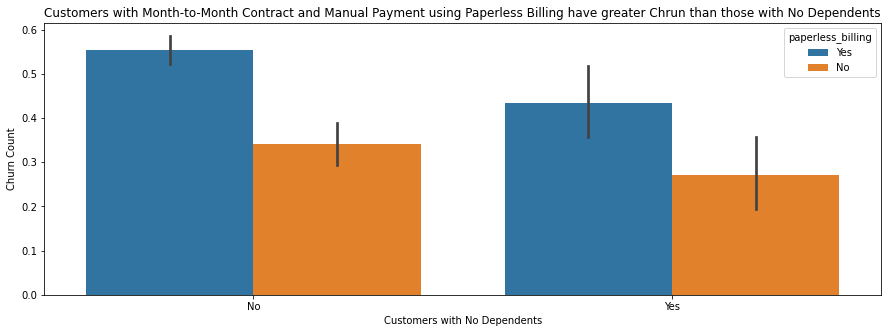

In [18]:
# Shows Month-to-Month and Manual Pay customers using Paperless Billing churn more than customers with no dependents
y = df_mpay.churn_yes
x = df_mpay.dependents
hue = df_mpay.paperless_billing
plt.figure(figsize=(15,5))
sns.barplot(data=df_mpay, y=y, x=x, hue=hue )
plt.title('Customers with Month-to-Month Contract and Manual Payment using Paperless Billing have greater Chrun than those with No Dependents')
plt.xlabel('Customers with No Dependents')
plt.ylabel('Churn Count')
plt.show()

### Answer 6
- The visual shows that the average churn of customers that use paperless billing is higher than the averge churn of customers that have no dependents.
- The Independent T-Test has a probability lower than alpha indicating agreement with the visual



### Summary: Which customer is most likely to churn? 
#### Through exploration, by focusing on significant subgroups, and then focusing on people attributes instead of service attributes, customers that have the following attributes will churn.
- On Month-to-Month Contract
- Using Manual Pay
- Using Paperless Billing


### Features NOT being used for Modeling:
**Most Features Did Not Make a Significant Subgroup**
- Customer ID: Converted to index for csv delivery
- Gender: No significant subgroup difference between male and female
- Senior Citien: No sigificance difference in churn between categories
- Partner: No significant subgroup difference between partner status subgroup
- Multiple Phone Lines: No sigfnificant subgroup difference between categories
- Online Backup: No significant subgroup difference between categories
- Device Protection: No significant subgroup difference between categories
- Streaming TV: No significant subgroup differnce between categories
- Streaming Movies: No significant subgroup difference between categories
- Phone Service: No significant churn differnce between categories
- Monthly Charges: Unable to differentiate between values
- Total Charges: Unable to differentiate between values
- Internet Service Type: No significant differency between categories

### Features USED for modeling:
**All Features Show Significant Difference in Churn Between Categories**
1. Dependents: Favored No
2. Tenure: Most Churn occurs within five months
3. Tech Support: Favored no
4. Online Security: Favored No
5. Contract Type: Baselined to Month-to-Month
6. Payment Type: Converted to Auto Pay and Manual Pay
7. Paperless Billing: Favored Yes


## Predicting Churn

Churn is a yes or no value so we will use classification machine learning algorithms to fit to our taining data and then evaluate against our validate data. We will pick the best model using **accuracy** and **precision** because predicting a churn and getting it wrong is favorable.
    
## Prep Data for Modeling

In [19]:
# run prep_teco to remove columns for modeling
train, validate, test = prep_telco.prep_telco(train,validate,test)

In [20]:
# run function to create x,y versions for train, validate, test
X_train, y_train, X_validate, y_validate, X_test, y_test = prep_telco.xy_version(train,validate,test)

### Baseline

The baseline prediction is set for predicting all customers to **Not Churn** or (churn == 0). Model results will be compared to the baseline.

In [21]:
# Create Baseline by setting all values to zero
baseline = (y_train == 0).mean()
baseline

0.7347197565305605

Baseline performed at 73% accuracy

## Develop 3 Models
- Selected models were are a Decision Tree, Random Forest, and K-Nearest Neighbor
- Models used the same features but differed in hyperparameters which were selected as best in a range

## Fit and Evaluate Train Data on Models
### Model 1: Decision Tree

In [22]:
# Using Decision Tree because it is easier to understand
# Create Decision Tree Classifier Algorithym Container
clf = DecisionTreeClassifier(max_depth=4, random_state=123)

In [23]:
# Fit Train Data to Container to make the model
clf = clf.fit(X_train, y_train)

In [24]:
# Create Prediction Series
y_pred_clf = clf.predict(X_train)

In [25]:
#Confusion Matrix for Model 1
labels = sorted(y_train.unique())
print('Actual on Left, Predicted on Top')
pd.DataFrame(confusion_matrix(y_train, y_pred_clf), index=labels, columns=labels)

Actual on Left, Predicted on Top


,0,1
0,2656,241
1,555,491


In [26]:
# Create Classification Report for Model 1
print(classification_report(y_train, y_pred_clf))

              precision    recall  f1-score   support

           0       0.83      0.92      0.87      2897
           1       0.67      0.47      0.55      1046

    accuracy                           0.80      3943
   macro avg       0.75      0.69      0.71      3943
weighted avg       0.79      0.80      0.79      3943



### Evaluate:
- Accuracy: 80%
- Precision: 67%
- Predicted 732 churns of which 241 were false 

### Model 2: Random Forest

In [27]:
# Using Random Forest to see if Accuracy and Precision increase
# Create Random Forest Classifier Algorithym Container
rf = RandomForestClassifier(max_depth=4, random_state=123)

# Fit Train Data to Container to make the model
rf = rf.fit(X_train, y_train)

# Create Prediction Series
y_pred_rf = rf.predict(X_train)

In [28]:
##Confusion Matrix for Model 2
labels = sorted(y_train.unique())
print('Actual on Left, Predicted on Top')
pd.DataFrame(confusion_matrix(y_train, y_pred_rf), index=labels, columns=labels)

Actual on Left, Predicted on Top


,0,1
0,2700,197
1,600,446


In [29]:
# Create Classification Report for Model 2
print(classification_report(y_train, y_pred_rf))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87      2897
           1       0.69      0.43      0.53      1046

    accuracy                           0.80      3943
   macro avg       0.76      0.68      0.70      3943
weighted avg       0.79      0.80      0.78      3943



### Evaluate:
- Accuracy: 80%
- Precision: 69%
- Predicted 643 churns of which 197 were false

### Model 3: K-Nearest Neighbor

In [30]:
# Using KNN to see if Accuracy and Precision increase
# Create Decision Tree Classifier Algorithym Container
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

# Fit Train Data to Container to make the model
knn = knn.fit(X_train, y_train)

# Create Prediction Series
y_pred_knn = knn.predict(X_train)

In [31]:
##Confusion Matrix for Model 3
labels = sorted(y_train.unique())
print('Actual on Left, Predicted on Top')
pd.DataFrame(confusion_matrix(y_train, y_pred_knn), index=labels, columns=labels)

Actual on Left, Predicted on Top


,0,1
0,2656,241
1,399,647


In [32]:
# Create Classification Report for Model 3
print(classification_report(y_train, y_pred_knn))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89      2897
           1       0.73      0.62      0.67      1046

    accuracy                           0.84      3943
   macro avg       0.80      0.77      0.78      3943
weighted avg       0.83      0.84      0.83      3943



### Evaluate:
- Accuracy: 84%
- Precision: 73%
- Predicted 888 of which 241 were false

### Evaluation Summary:

- K-Nearest Neighbor (Model 3) performed the best at 84% accuracy and 73% Precision. 
- Models do not appear to be overfit
- Going forward with all models as there wasn't much difference in accuracy between them

## Evaluate Validate Data with Models
### Model 1: Decision Tree

In [33]:
# Create Prediction Series
y_pred_clf = clf.predict(X_validate)

In [34]:
#Confusion Matrix for Model 1
labels = sorted(y_validate.unique())
print('Actual on Left, Predicted on Top')
pd.DataFrame(confusion_matrix(y_validate, y_pred_clf), index=labels, columns=labels)

Actual on Left, Predicted on Top


,0,1
0,1111,131
1,232,217


In [35]:
# Create Classification Report for Model 1
print(classification_report(y_validate, y_pred_clf))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1242
           1       0.62      0.48      0.54       449

    accuracy                           0.79      1691
   macro avg       0.73      0.69      0.70      1691
weighted avg       0.77      0.79      0.78      1691



### Evaluate:
- Accuracy: 79%
- Precision: 62%
- Predicted 348 churns of which 131 were false

### Model 2: Random Forest

In [36]:
# Create Prediction Series
y_pred_rf = rf.predict(X_validate)

In [37]:
##Confusion Matrix for Model 2
labels = sorted(y_validate.unique())
print('Actual on Left, Predicted on Top')
pd.DataFrame(confusion_matrix(y_validate, y_pred_rf), index=labels, columns=labels)

Actual on Left, Predicted on Top


,0,1
0,1156,86
1,247,202


In [38]:
# Create Classification Report for Model 2
print(classification_report(y_validate, y_pred_rf))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87      1242
           1       0.70      0.45      0.55       449

    accuracy                           0.80      1691
   macro avg       0.76      0.69      0.71      1691
weighted avg       0.79      0.80      0.79      1691



### Evaluate:
- Accuracy: 80%
- Precision: 70%
- Predicted 290 of which 88 were false

### Model 3: K-Nearest Neighbor

In [39]:
# Create Prediction Series
y_pred_knn = knn.predict(X_validate)

In [40]:
##Confusion Matrix for Model 3
labels = sorted(y_train.unique())
print('Actual on Left, Predicted on Top')
pd.DataFrame(confusion_matrix(y_validate, y_pred_knn), index=labels, columns=labels)

Actual on Left, Predicted on Top


,0,1
0,1072,170
1,209,240


In [41]:
# Create Classification Report for Model 3
print(classification_report(y_validate, y_pred_knn))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1242
           1       0.59      0.53      0.56       449

    accuracy                           0.78      1691
   macro avg       0.71      0.70      0.70      1691
weighted avg       0.77      0.78      0.77      1691



### Evaluate:
- Accuracy: 78%
- Precision: 59%
- Predicted 410 churns of which 170 were false

### Evaluation Summary:
Random Forest (Model 2) did slightly better on the validate sample with 80% accuracy and 59% precision. It is also less overfit than K-Nearest Neighbor (Model 3). Going forward with Random Forest.

## Evaluate Test Data with Model 2
### Model 2: Random Forest

In [42]:
# Create Prediction Series
y_pred_rf = rf.predict(X_test)

In [43]:
##Confusion Matrix for Model 2
labels = sorted(y_test.unique())
print('Actual on Left, Predicted on Top')
pd.DataFrame(confusion_matrix(y_test, y_pred_rf), index=labels, columns=labels)

Actual on Left, Predicted on Top


,0,1
0,958,77
1,208,166


In [44]:
# Create Classification Report for Model 2
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87      1035
           1       0.68      0.44      0.54       374

    accuracy                           0.80      1409
   macro avg       0.75      0.68      0.70      1409
weighted avg       0.78      0.80      0.78      1409



### Evaluate
- Accuracy: 80%
- Precision: 68%
- Predicted 243 of which 77 are false

### This model is expected to perform with 80% accuracy on unseen data assuming there are no major changes in our data source. 

## Conclusion

### Summary
Initial Questions:
1. How many customers are churning and not churning?

2. What is the timeline of churn?

3. At what month of tenure are they churning?

4. What non-monetary drivers are associated with churned customers?

5. What monetary drivers are associated with churned customers?

6. Do monetary drivers outweigh non-monetary drivers?

7. What drivers are easiest to change with least amount of impact to the customer?

The questions changed through exploration and the following is what I learned:

- Churn is problem with 27% of customers churning and the highest churn happening at month 1 of tenure.
- People attributes were greater than service attributes in amounts of significant attributes and churn.
- Top 3 attributes associated with churn: month-to-month contract, manual payments, paperless billing.
- Using the Random Forest Model, expect 80% accuracy with predicting customers that will churn.

### Recommendations
Use the model to predict customers that will churn and promote to those customers a transition to annual contracts, auto payments, or paper billing.

### Next Steps
- With more time, I would explore why churn is occuring highest at first tenure month. 
- What is about the first month of service that people don't like?
- Create a service cancellation survey?

### Thank you